<a href="https://colab.research.google.com/github/noobmaster-ru/DLS_part1/blob/main/week3/model_selection_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

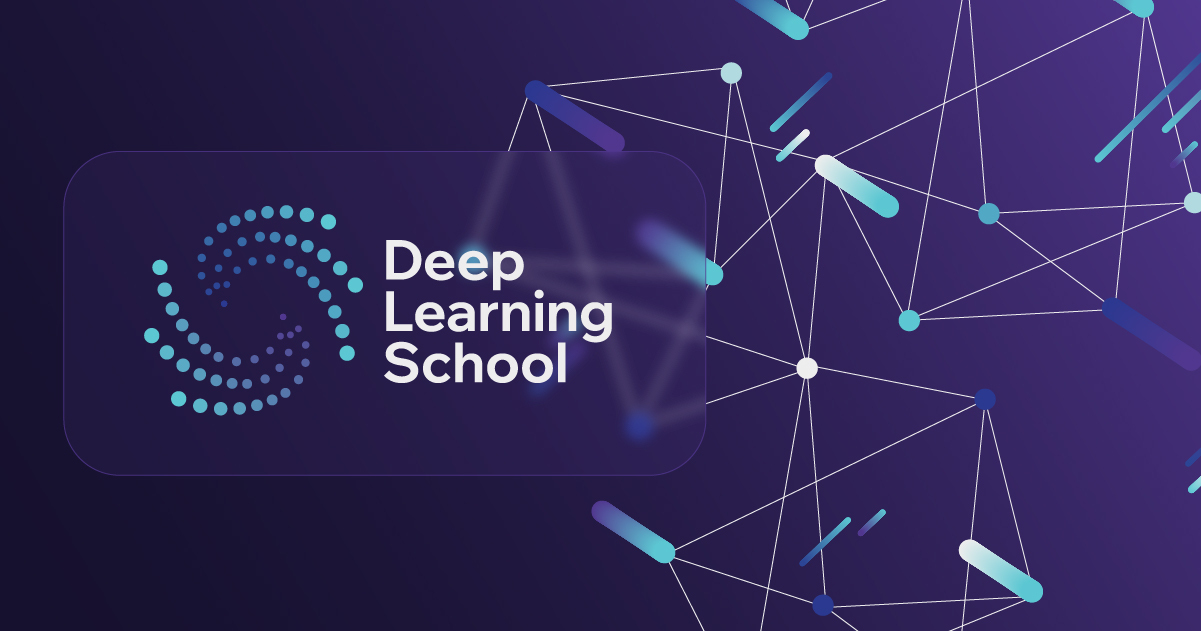

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Композиция алгоритмов и выбор модели</b></h1>

В этом семинаре вы узнаете о том, как создаются модели машинного обучения для решения настоящих задач.

# План
1. Напоминание: переобучение, регуляризация и кросс-валидация
2. Pipeline решения ML задачи
3. Подбор гиперпараметров и ансамблирование моделей на примере размеченных данных

In [70]:
# Установим зависимости. Эти пакеты понадобятся для обучения бустингов.
!pip install xgboost -q
!pip install catboost -q

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

from tqdm.notebook import tqdm

# Подготовка данных
from sklearn.preprocessing import StandardScaler

# Оценка моделей
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# Метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Бустеры
import catboost # документация: https://catboost.ai/docs
import xgboost

# Подавление предупреждений
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Переобучение и методы борьбы с ним
Переобучение --- это одна из главных проблем, с которыми сталкиваются модели машинного обучения. Эффект переобучения состоит в том, что модель, подстраиваясь под обучающую выборку, "обращает внимание" на закономерности в выборке, которые не проявляются в общем случае и имеют характер совпадения.

Переобучение проявляется тем больше, чем больше степеней свободы имеет модель.
### Примеры:
* Решающее дерево со слишком большой глубиной может идеально подстроиться под обучающую выборку. Параметры решающего дерева --- это решающие правила во всех вершинах (всего $\sim 2^n$ решающих правил в дереве глубины $n$).

* Алгоритм $k$ ближайших соседей подстраивается под обучаюущую выборку и может рассматриваться как эталонный пример переобучения: любой локальный шум в данных приведёт к ошибке. Параметрами Knn являются **все элементы обучающей выборки**.

* Линейный алгоритм, построенный для выборки слишком маленького размера со слишком большим количеством признаков неизбежно переобучится под обучающую выборку.

Во всех примерах мы видим, что при слишком большой сложности модели по сравнению с количеством элементов в обучающей выборке переобучение имеет место. Строго говоря, **переобучение есть всегда, когда имеет место принятие решения в условии неполных данных**, то есть всегда в машинном обучении.

<img src='https://drive.google.com/uc?id=1wQQ0tMAtZVhbeQgUVdiS7kfmMw7P7NM9'/>

Чтобы избежать переобучения, нужно поймать момент, в который качество на тестовой выборке начинает снижаться с ростом сложности модели. В этот момент обучение стоит останавливать.

## Переобучение многочленов
Смоделируем переобучение полиномиальной зависимости с ростом степени многочлена. Сгенерируем искусственные данные из линейной зависимости с шумом и восстановим зависимость с помощью многочленов степени 1, 3, 4, 7.

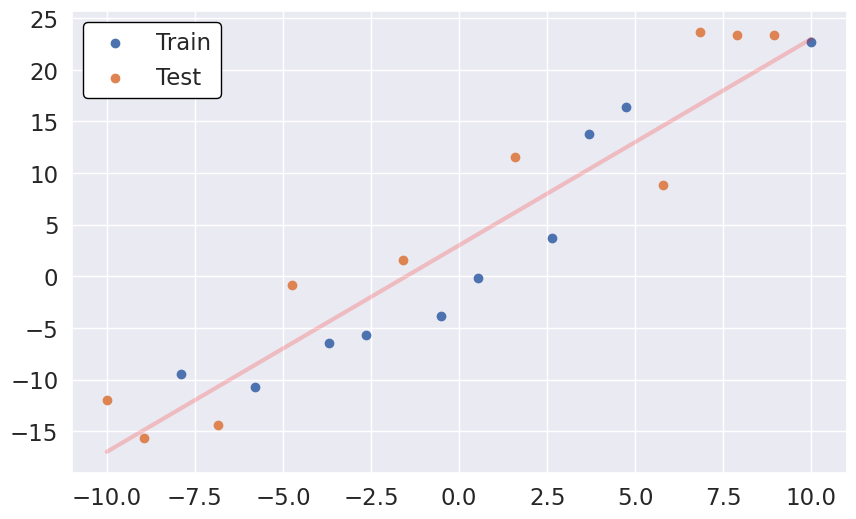

In [72]:
# Генерируем искусственные данные из линейной зависимости с шумом
X = np.linspace(-10, 10, 20)

y = 2 * X + 3 + np.random.randn(20) * 3

# Разделим данные на обучающие и тестовые данные для контроля переобучения
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train, label='Train')
plt.scatter(X_test,y_test, label='Test')
plt.plot(X, 2 * X + 3, color='red', lw=3, alpha = 0.2)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

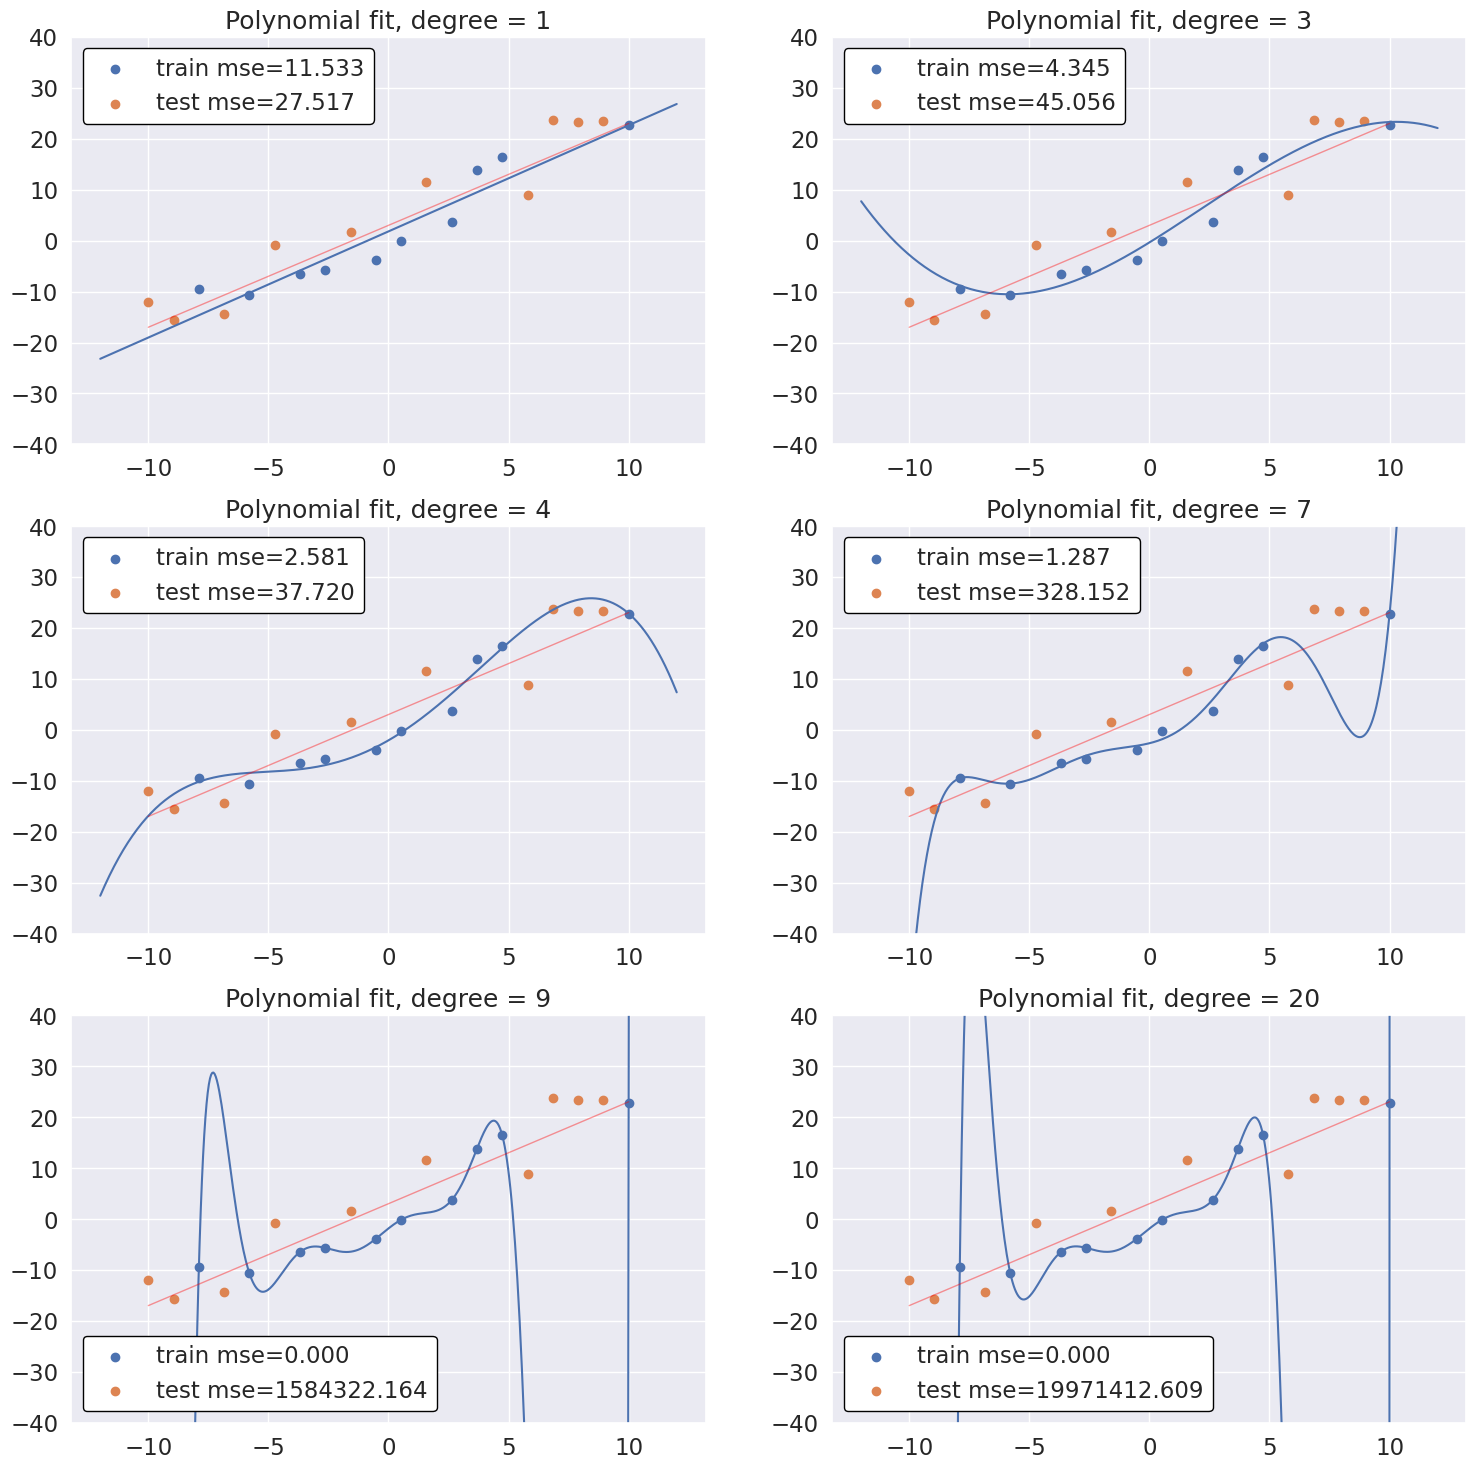

In [73]:
# Теперь аппроксимируем обучающие данные с помощью полиномов разных степеней
grid = np.linspace(-12, 12, 500)

fig, ax = plt.subplots(3, 2, figsize=(18,18))

ax = ax.ravel()

for i, deg in enumerate([1,3,4,7,9, 20]):

    poly = np.polyfit(X_train, y_train, deg)
    ax[i].set_title('Polynomial fit, degree = ' + str(deg))
    ax[i].scatter(X_train,y_train,
                  label='train mse={:.3f}'.format(mean_squared_error(y_train, np.polyval(poly, X_train))))
    ax[i].scatter(X_test,y_test,
                  label='test mse={:.3f}'.format(mean_squared_error(y_test, np.polyval(poly, X_test))))
    ax[i].set_ylim(-40, 40)
    ax[i].plot(grid, np.polyval(poly, grid))

    ax[i].plot(X, 2 * X + 3, color='red', lw=1, alpha = 0.4)
    legend_box = ax[i].legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
fig.show()

**Что такое норма?**\
Нормой (или нормой вектора) называется числовая характеристика, которая определяет "размер" вектора в пространстве. Норма является обобщением понятия длины для векторов в многомерных пространствах.\
В данном случае представлены две формулы для вычисления евклидовой нормы (L2-нормы):

a) Для 2-мерного пространства:
$$||x-y||, \text{x, y - векторы в 2-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + (x_2-y_2)^2}$$


b) Для n-мерного пространства:
$$||x-y||, \text{x, y - векторы в n-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + ... + (x_n-y_n)^2}$$

### Идея 1: регуляризация
Суть регуляризации состоит в том, чтобы добавлять к функции потерь слагаемое, ограничивающее рост весов модели. Например, обычная версия линейной регрессии выглядит так:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} \rightarrow \min_{w}.$$

Регуляризованная версия:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} + \frac{1}{C}\left|\left|w\right|\right|_2^2\rightarrow \min_{w}.$$

Здесь:

- Первое слагаемое — это сумма квадратов ошибок (MSE).
- Второе слагаемое — это L2-норма вектора весов w, умноженная на коэффициент $\frac{1}{C}\$.

Такая версия линейной регресси называется [**Ridge-регрессией**](https://scikit-learn.ru/stable/modules/kernel_ridge.html).
  
Есть также [**Lasso-регрессия**](https://scikit-learn.ru/stable/modules/linear_model.html#lasso).

Обычная версия логрегрессии:
$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right)\rightarrow \min_{w}$$

Регуляризованная версия:

$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right) + \frac{1}{C}||w||_1\rightarrow \min_{w}$$
Здесь:

- ∣∣w∣∣ — это L1-норма вектора весов w

<br><br>
и [**ElasticNet**](https://scikit-learn.ru/stable/modules/linear_model.html#elastic-net) - это комбинация L1 и L2-регуляризации.

### Идея 2: кросс-валидация

**Кросс-валидация** (или **перекрёстная проверка**) — это метод оценки производительности и обобщающей способности моделей машинного обучения. Она используется для того, чтобы понять, насколько хорошо модель будет работать на новых, ранее не виденных данных. Кросс-валидация помогает избежать переобучения (overfitting) и более точно оценить качество модели.

**Основная идея**

Данные разбиваются на несколько частей (подмножеств), после чего модель обучается на одной части данных и проверяется на другой. Этот процесс повторяется несколько раз, чтобы каждая часть данных побывала в роли валидационного набора.

<img src='https://drive.google.com/uc?id=19TOWCsLwIjNSmcHzu46f6JqY5TEefm9h' width=600/>
Картинка говорит сама за себя. Чтобы получить более стабильное предсказание и точно увидеть переобучение, можно использовать кросс-валидацию. Это ещё пригодится дальше в ноутбуке.

# Pipeline решения ML-задачи

![lifecycle.png](https://drive.google.com/uc?export=view&id=1ZVVA3knTV7M0sTANYF4kOSMAZWG_BB5j)

![pipeline.jpg](https://drive.google.com/uc?export=view&id=1wt86eJI3wDb4SuRKFdtjvqKDaW0UDLvz)

# Выбор оптимальной модели

Теперь мы потренируемся обучению, оценке и валидации моделей, подбору оптимальных гиперпараметров, смешиванию моделей. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

In [74]:
# Загрузка данных в Пандас с URL
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')

# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() # этот метод разделит датасет по колонкам как в массиве columns (по пробелам)

df = df.replace('?', np.nan) # Заменяем значения '?' на пропуски

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x=='>50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [75]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


In [76]:
df['education'].unique(), len(df['education'].unique())

(array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', '7th-8th', 'Doctorate', 'Assoc-voc', 'Prof-school',
        '5th-6th', '10th', 'Preschool', '12th', '1st-4th'], dtype=object),
 16)

### One-hot кодирование
Поскольку все алгоритмы машинного обучения, которые мы изучили, работают лишь с числовыми признаками, необходимо придумать способ обработки категориальных признаков, переводящий их в числовые.
Одним из способов сделать это является One-hot кодирование. Его суть состоит в следующем. Пусть некоторая категориальная переменная (скажем, color) принимает $n$ различных значений (Red, Yellow, Green). Тогда можно создать $n$ новыx переменныx, соответствующих различным значениям категориального признака, каждая из которых равна 1 в том случае, если изначальный категориальный признак принимает такое значение, и 0 иначе. Принцип работы иллюстрирован на картинке.

<img src='https://drive.google.com/uc?id=17oipPzKv7JFU5Z94hBUzMb5zJJlpbwxj' width=700/>

В Pandas One-hot кодирование выполняется функцией pd.get_dummies. Сгенерируем One-hot признаки для нашего датасета. Сохраним полную матрицу объекты признаки в переменную X.

In [77]:
dummy_features = pd.get_dummies(categorial_data)

<span style="color: blue; font-weight: bold"> Замечание : </span>  ❌\
 Метод `pd.get_dummies` применяется скорее при анализе данных. Его стоит крайне осторожно применять в задачах ML, так как в общем случае он не обеспечивает воспроизводимость предобработки новых данных: если применить этот метод по отдельности на двух выборках, наборы сгенерированных one-hot столбцев могут различаться. Если в дальнейшем удалить названия столбцев (например, при конвертации в numpy array), сравнивать разные датасеты станет невозможно.

В ML пайплайнах предобработки данных для кодировки категориальных переменных в реальных задачах используют обучаемые Энкодеры, которые не только сохраняют словарь кодировки и могут работать с данными, в которых другое распределнеие значений в категориях, но и исключают утечку данных между обучающей и тестовой выборками. Кроме того, их обучение можно объединить с обучением моделей в специальных конвеерах (Pipeline), что исключает утечку между выборками даже при кросс-валидации и делает валидацию валидной.

In [78]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,38,215646,9,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,53,234721,7,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,28,338409,13,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,37,284582,14,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [79]:
y = df['salary']

In [80]:
X.shape, X_origin.shape

((30161, 104), (30161, 14))

Теперь всё готово для обучения алгоритмов.

In [81]:
# Откладываем выборку для тестов моделей
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    train_size=0.8,
                                                    random_state=42)

Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Используем идею кросс-валидации.

In [82]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    """
    Выполняет поиск по сетке гиперпараметров модели и визуализирует результаты.

    Параметры:
    ----------
    X : array-like of shape (n_samples, n_features)
        Обучающие данные. Матрица признаков.
    y : array-like of shape (n_samples,)
        Целевые значения для обучающих данных.
    model : estimator object
        Экземпляр модели машинного обучения, который будет использоваться для поиска по сетке.
    param_name : str
        Название параметра модели, который будет изменяться в процессе поиска по сетке.
    grid : array-like
        Сетка значений для параметра, который будет исследован.
    param_scale : {'ordinary', 'log'}, optional (default='ordinary')
        Определяет шкалу для оси x на графике. Если 'log', то используется логарифмическая шкала.
    draw : bool, optional (default=True)
        Флаг, указывающий, нужно ли строить график результатов поиска по сетке.

    Возвращает:
    -----------
    means : ndarray of shape (len(grid),)
        Средние значения метрики качества модели для каждого значения параметра из сетки.
    error : ndarray of shape (len(grid),)
        Стандартные отклонения метрики качества модели для каждого значения параметра из сетки.

    Примечания:
    ------------
    Функция использует GridSearchCV для выполнения кросс-валидации с использованием метрики F1.
    Если флаг draw установлен в True, то строится график зависимости среднего значения метрики
    качества модели от значения параметра. На графике также показаны интервалы ошибок.
    """
    parameters = {param_name: grid}

    CV_model = GridSearchCV(estimator=model,
                            param_grid=parameters,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1,
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']

    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error,
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()

    return means, error

In [83]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


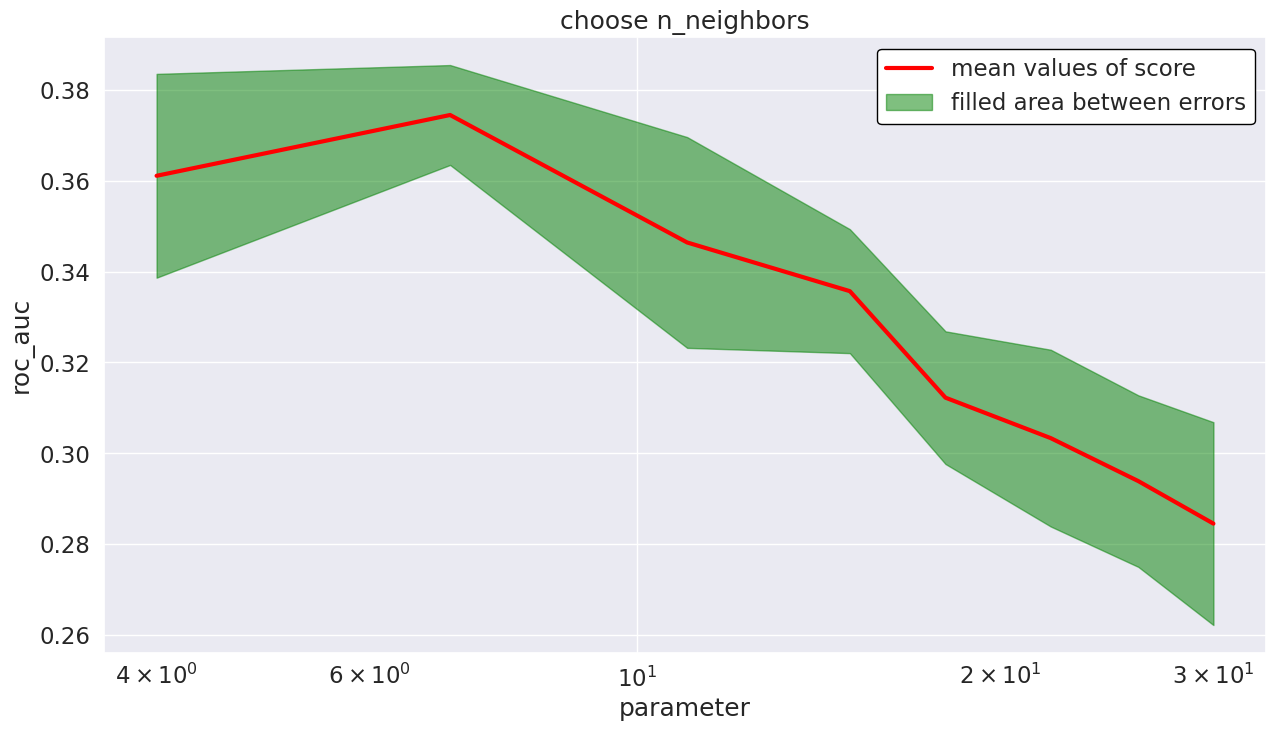

Fitting 5 folds for each of 29 candidates, totalling 145 fits


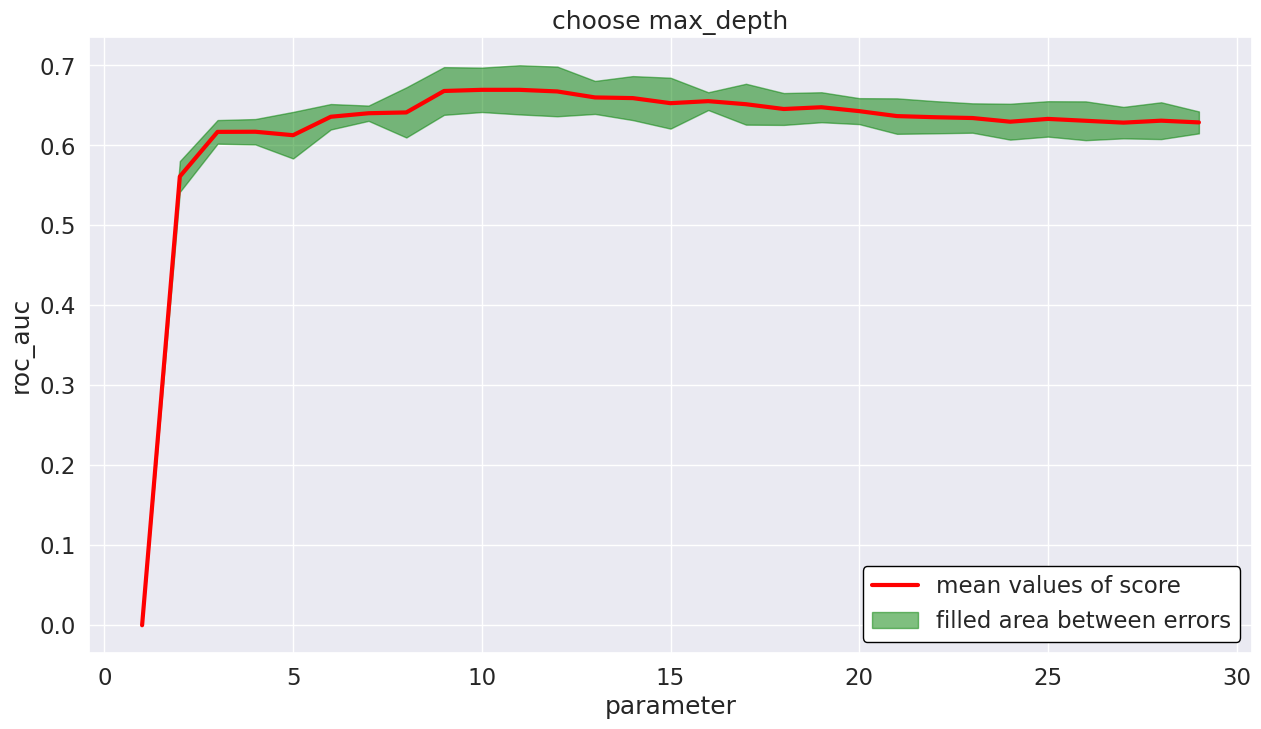

In [84]:
for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется.
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

In [85]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

# Явно распишем цикл кросс-валидации для подбора гиперпараметра модели
for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []

    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]

    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]

    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_

    # Оцениваем модели по сетке параметра.
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)

        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))

    scores = np.array(scores)

    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

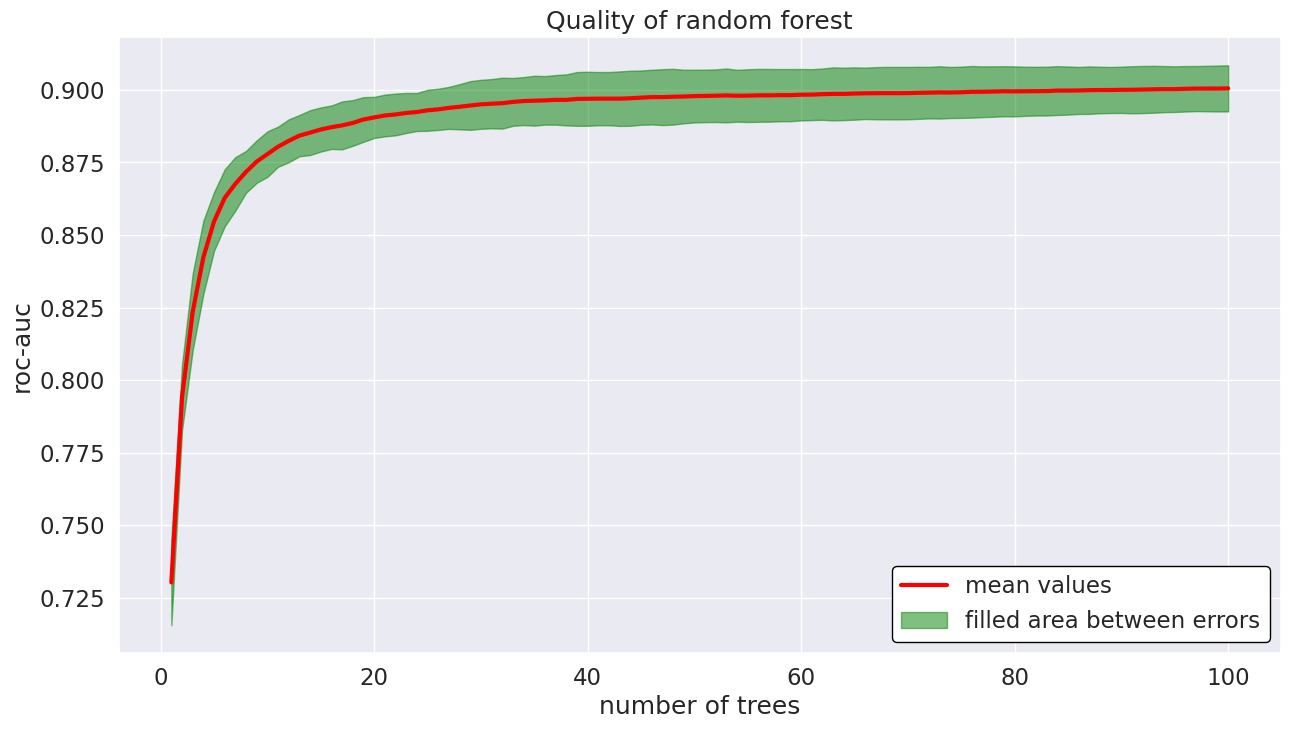

In [86]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values,
                 mean_cross_val_score - 2 * std_cross_val_score,
                 mean_cross_val_score + 2 * std_cross_val_score,
                 color='green',
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

### Нормировка признаков

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания.

In [87]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<span style="color: blue; font-weight: bold">Замечание: </span>  ❌\
 Здесь `StandardScaler()` обучается на обучающей выборке и масштабирует тестовую используя параметры обучающих данных. Таким образом утечек информации между выборками нет.

Но при кросс-валидации это требование не выполняется, поскольку `StandardScaler()` обучен на всех данных подающихся в кросс-валидацию, без разделения на обучающие и валидационные данные. Чуть ниже добавлен уточненный код для нормировки признаков внутри кросс-валидации.

`StandardScaler` выполняет преобразование $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$

Fitting 5 folds for each of 8 candidates, totalling 40 fits


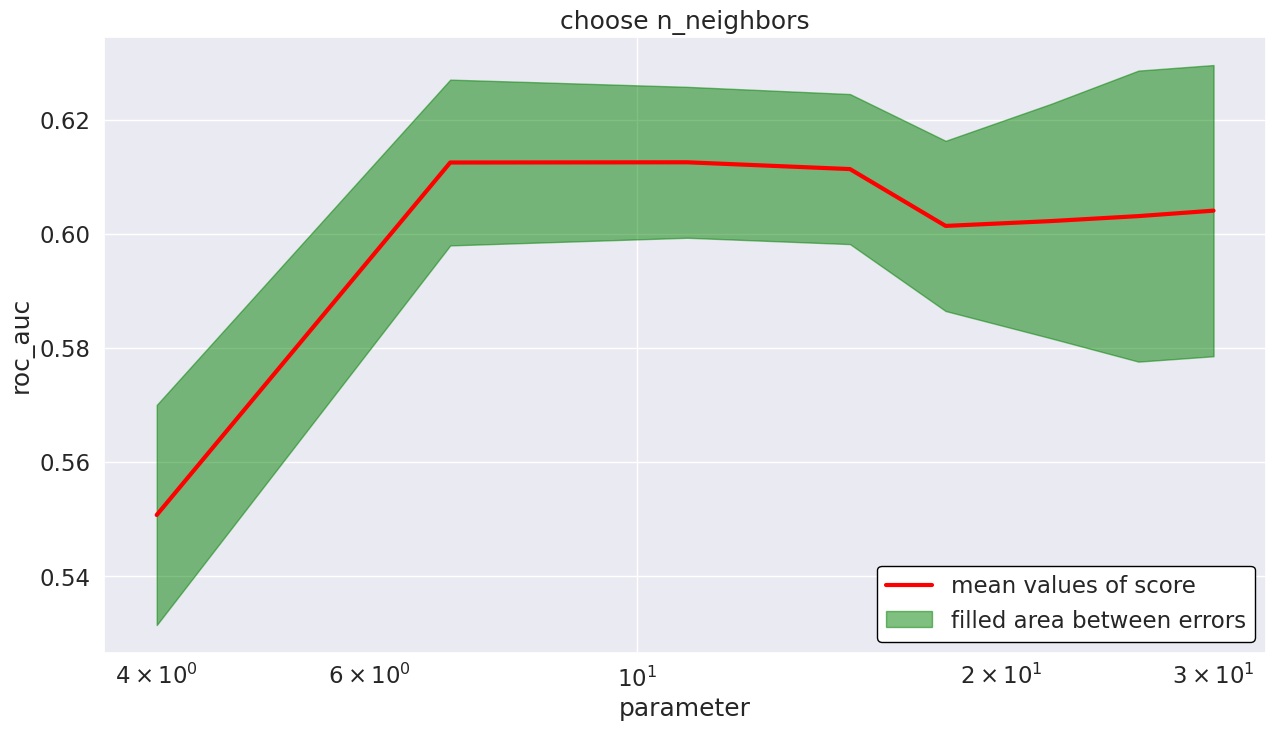

In [88]:
search_and_draw(X_train_scaled, y_train, KNeighborsClassifier(), 'n_neighbors',
                np.array(np.linspace(4, 30, 8), dtype='int'), 'log');

Ниже представлен уточненный вариант - реализация `StandardScaler()` внутри `GridSearchCV()`. Для этого в нашу функцию `search_and_draw()` в качестве параметра model будем передавать `Pipeline`, объединяющий `StandardScaler()` и `KNeighborsClassifier()`. Про доступ к внутренним параметрам `Pipeline` можно почитать здесь: https://scikit-learn.ru/stable/modules/compose.html#pipeline-nested-parameters (в т.ч. под катом  "Когда это имеет значение?")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


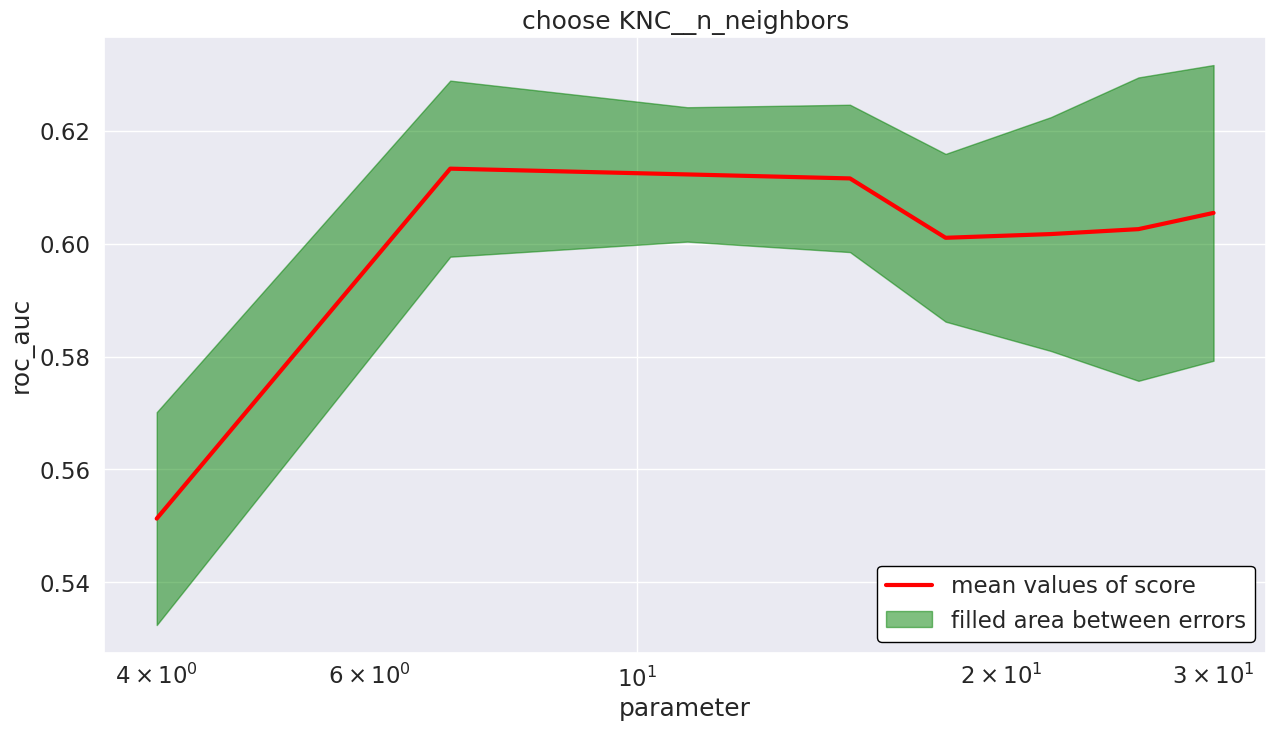

In [89]:
# Уточненный код. В этом случае предварительное применение StandardScaler() для X_train и X_test не производится
from sklearn.pipeline import Pipeline

pipe_KNC = Pipeline(steps = [('StSc', StandardScaler()), ('KNC', KNeighborsClassifier())])

search_and_draw(X = X_train, y = y_train, model = pipe_KNC, param_name = 'KNC__n_neighbors',
                grid = np.array(np.linspace(4, 30, 8), dtype='int'), param_scale='log');

Как и следовало ожидать, ни один из наших алгоритмов не побил случайный лес. Итак, видим, что на больших выборках бэггинг работает. Вычислим итоговое качество на test.

In [90]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

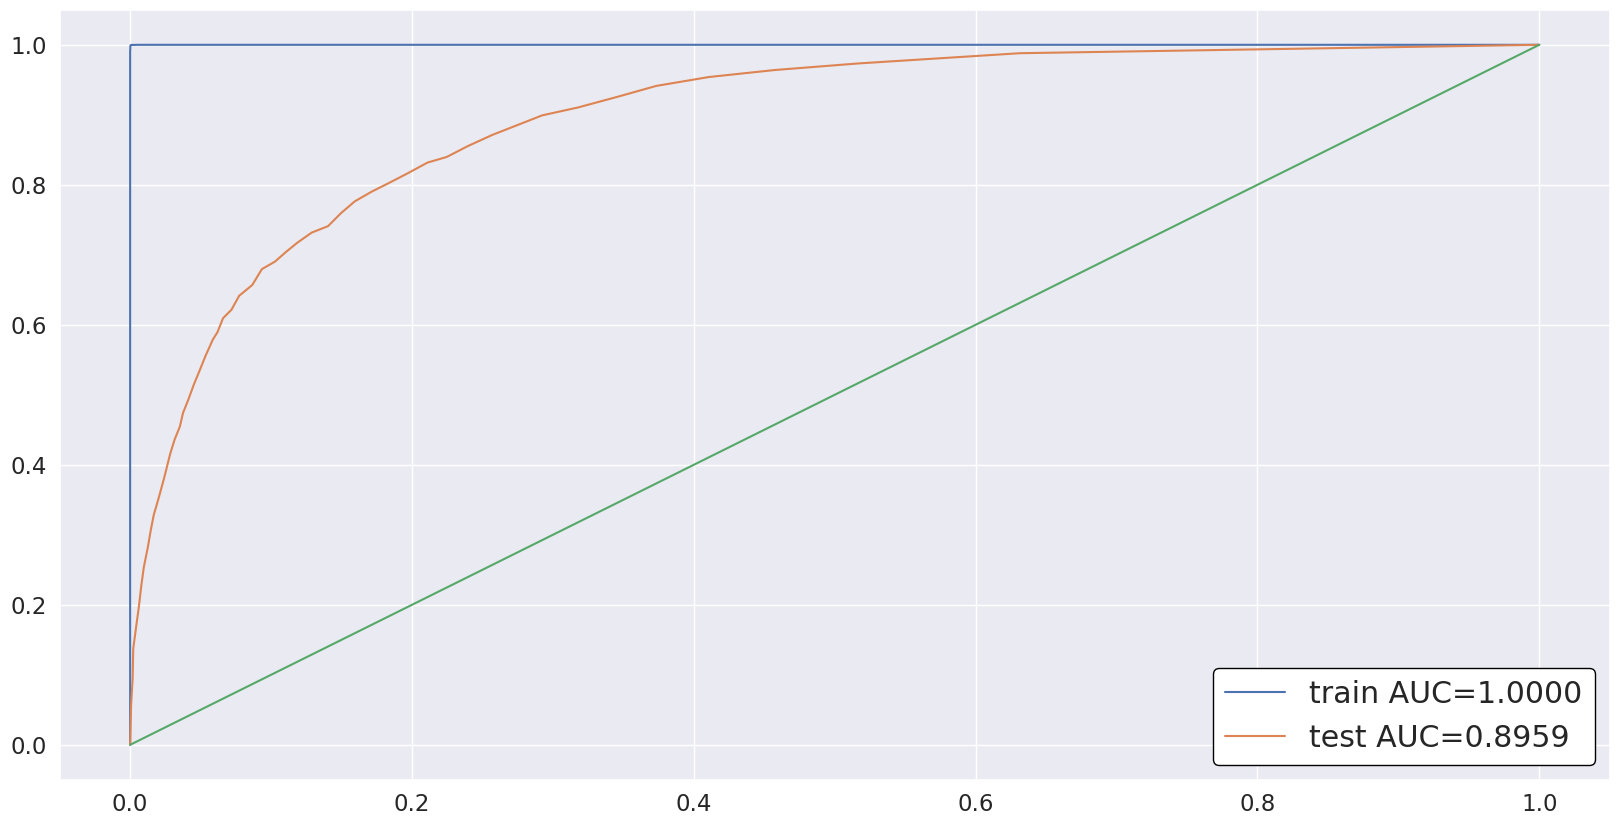

In [91]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов.

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

In [92]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    """
    Вычисляет мета-признаки для стекинга, используя кросс-валидацию и предсказания модели.

    Параметры:
    ----------
    model : estimator object
        Экземпляр модели машинного обучения, которая будет использоваться для вычисления мета-признаков.
    X_train : array-like of shape (n_samples, n_features)
        Матрица признаков обучающей выборки.
    X_test : array-like of shape (n_samples_test, n_features)
        Матрица признаков тестовой выборки.
    y_train : array-like of shape (n_samples,)
        Целевые значения для обучающей выборки.
    cv : int, cross-validation generator or an iterable, optional
        Определяет стратегию кросс-валидации. Может быть целым числом (количество фолдов) или объектом типа кросс-валидатора.

    Возвращает:
    -----------
    train_answers : ndarray of shape (n_samples,)
        Предсказанные вероятности класса для обучающей выборки, полученные с помощью кросс-валидации.
    test_answers : ndarray of shape (n_samples_test,)
        Предсказанные вероятности класса для тестовой выборки, полученные после обучения модели на всей обучающей выборке.

    Примечания:
    ------------
    Функция сначала выполняет кросс-валидацию на обучающей выборке для получения мета-признаков (train_answers).
    Затем модель обучается на всей обучающей выборке, и предсказываются вероятности класса для тестовой выборки (test_answers).
    Если модель не поддерживает метод 'predict_proba', используется метод 'predict' для получения мета-признаков.
    """
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]

    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [93]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [94]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [95]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [96]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

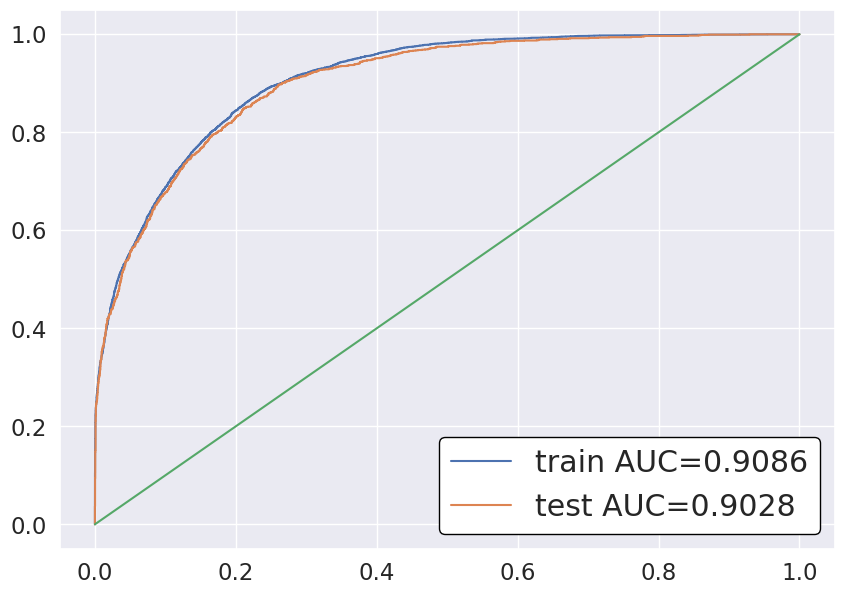

In [97]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Бустинг

Попробуем в пару-тройку строк побить всё то качество, которое мы так усердно искали.

In [98]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

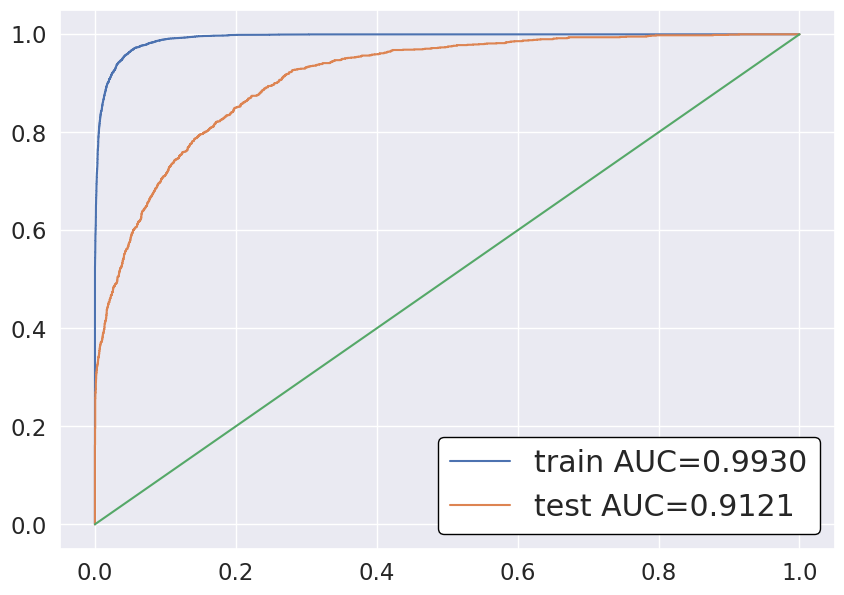

In [99]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Круто, да? А теперь попробуем "отечественного" производителя - CatBoost от Яндекса.

In [100]:
# CatBoost умеет работать с категориальными признаками сам
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values,
                                                       train_size=0.8,
                                                       random_state=42)

![docs_one_hot.png](https://drive.google.com/uc?export=view&id=119U7_cTX8imN13rr3Bi-vevHjo7kEXr6)

(из документации CatBoost)

In [101]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200,
                                             cat_features=categorical_indices)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.175479
0:	learn: 0.5372165	total: 80.4ms	remaining: 16s
1:	learn: 0.4526979	total: 140ms	remaining: 13.9s
2:	learn: 0.4081255	total: 213ms	remaining: 14s
3:	learn: 0.3778820	total: 269ms	remaining: 13.2s
4:	learn: 0.3566011	total: 331ms	remaining: 12.9s
5:	learn: 0.3455788	total: 395ms	remaining: 12.8s
6:	learn: 0.3350149	total: 462ms	remaining: 12.7s
7:	learn: 0.3268511	total: 532ms	remaining: 12.8s
8:	learn: 0.3229313	total: 593ms	remaining: 12.6s
9:	learn: 0.3186000	total: 653ms	remaining: 12.4s
10:	learn: 0.3160912	total: 711ms	remaining: 12.2s
11:	learn: 0.3135176	total: 767ms	remaining: 12s
12:	learn: 0.3106304	total: 830ms	remaining: 11.9s
13:	learn: 0.3088799	total: 888ms	remaining: 11.8s
14:	learn: 0.3069790	total: 952ms	remaining: 11.7s
15:	learn: 0.3054777	total: 1.01s	remaining: 11.6s
16:	learn: 0.3045585	total: 1.1s	remaining: 11.9s
17:	learn: 0.3026705	total: 1.16s	remaining: 11.8s
18:	learn: 0.3018712	total: 1.23s	remaining: 11.7s
19:	learn: 0.3008

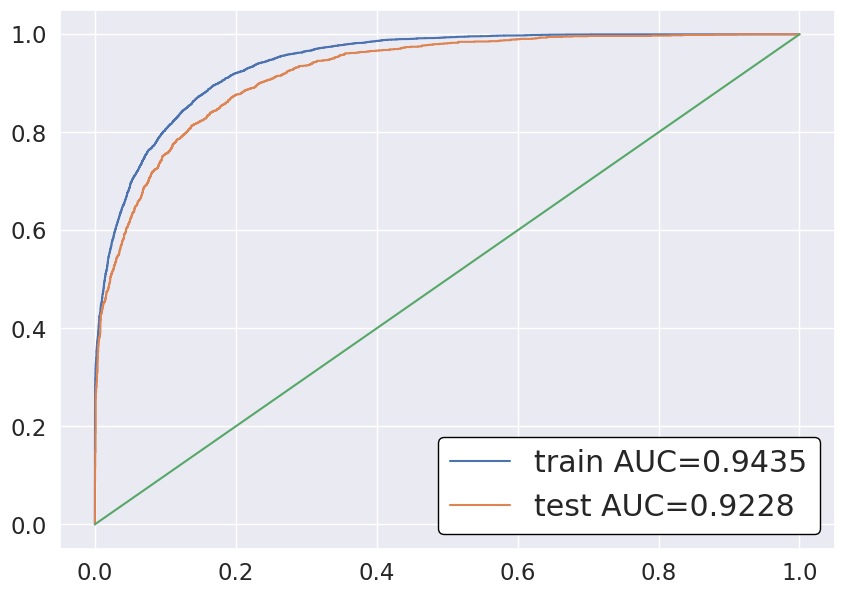

In [102]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [103]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, logging_level='Silent',
                                             cat_features=categorical_indices,
                                             eval_metric='AUC')
boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20)},
                           X_train_origin,
                           y_train, plot=True, refit=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate

In [104]:
y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

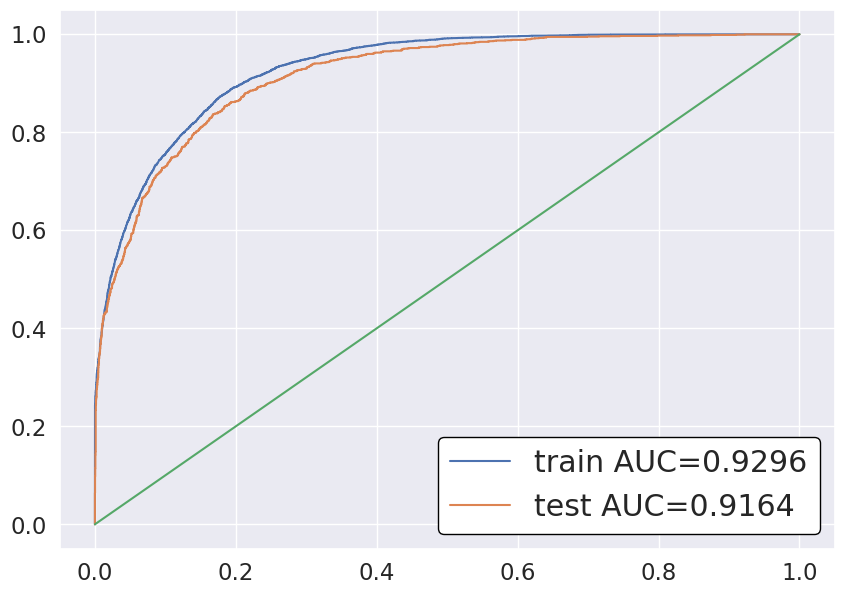

In [105]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Резюме по занятию.

1. Предобработка данных :
- Были загружены данные из UCI репозитория, содержащие информацию о доходах людей.
- Выполнено разделение признаков на числовые и категориальные, а также проведена обработка пропущенных значений.
- Для категориальных признаков было применено One-hot кодирование, что позволило преобразовать их в числовой формат, необходимый для обучения моделей машинного обучения.
2. Методы борьбы с переобучением :
- Обсуждены основные методы борьбы с переобучением, такие как регуляризация и кросс-валидация.
- Показано влияние степени многочленов на качество модели: слишком высокая степень приводит к переобучению, а низкая — к недообучению.
3. Подбор гиперпараметров :
- Использована кросс-валидация для подбора оптимальных гиперпараметров для нескольких моделей (KNN, решающее дерево, случайный лес).
- Демонстрируется зависимость качества модели от изменения гиперпараметров, таких как количество соседей в KNN или глубина дерева в решающем дереве.
4. Нормировка признаков :
- Применена нормировка признаков для алгоритма ближайших соседей, что значительно улучшило его производительность.
5. Ансамблирование моделей :
- Рассмотрены различные подходы к ансамблированию моделей, такие как стекинг и бустинг.
- Стекинг показал хорошие результаты, но не смог превзойти случайный лес по качеству прогноза.
- Бустинговые модели (XGBoost и CatBoost) продемонстрировали лучшие результаты по сравнению с другими алгоритмами, причём CatBoost особенно выделялся возможностью работы с категориальными признаками без дополнительного кодирования.
## Итоги :
- Наилучшие результаты были достигнуты с использованием бустинговых моделей, которые за счёт последовательного добавления слабых учеников смогли достичь более высокого качества предсказания.
- Ансамблирование моделей является мощным инструментом для улучшения качества прогноза, однако требует тщательной настройки и большого объёма данных для достижения максимальной эффективности.
- Важно помнить о необходимости использования воспроизводимых методов предобработки данных, таких как обучаемые энкодеры, чтобы исключить утечки информации между обучающей и тестовой выборками.